# Adding activity chains to synthetic populations 

The purpose of this script is to match each individual in the synthetic population to a respondant from the [National Travel Survey (NTS)](https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=5340). 

### Methods

We will try two methods

1. categorical matching: joining on relevant socio-demographic variables
2. statistical matching, as described in [An unconstrained statistical matching algorithm for combining individual and household level geo-specific census and survey data](https://doi.org/10.1016/j.compenvurbsys.2016.11.003). 

In [1]:
import numpy as np
import pandas as pd

## Step 1: Load in the datasets  

### SPC 

In [2]:
# useful variables
region = "west-yorkshire"

In [3]:
# Read in the spc data (parquet format)
spc = pd.read_parquet('../data/spc_output/' + region + '_people_hh.parquet')
spc.head()

,id,household,workplace,location,events,weekday_diaries,weekend_diaries,orig_pid,id_tus_hh,id_tus_p,...,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8
0,0,0,NaN,"{'x': -1.7892179489135742, 'y': 53.91915130615...","{'concert_f': 1.2791347489984115e-31, 'concert...","[1583, 13161]","[1582, 13160]",E02002183_0001_001,11291218,1,...,1.0,NaN,2.0,True,2.0,2,1,86,1,1.0
1,1,1,NaN,"{'x': -1.8262380361557007, 'y': 53.92028045654...","{'concert_f': 9.743248151956307e-21, 'concert_...","[2900, 4948, 4972, 7424, 10284, 10586, 12199, ...","[2901, 4949, 4973, 7425, 10285, 10585, 12198, ...",E02002183_0002_001,17291219,1,...,3.0,NaN,6.0,True,2.0,2,1,74,3,1.0
2,2,1,NaN,"{'x': -1.8262380361557007, 'y': 53.92028045654...","{'concert_f': 8.46716103992468e-16, 'concert_f...","[3010, 6389, 9448, 10184, 11598]","[3011, 6388, 9447, 10183, 11599]",E02002183_0002_002,17070713,2,...,3.0,NaN,6.0,True,2.0,2,2,68,1,2.0
3,3,2,56126.0,"{'x': -1.8749940395355225, 'y': 53.94298934936...","{'concert_f': 1.8844366073608398, 'concert_fs'...","[366, 867, 2096, 3678, 5212, 5450, 8145, 9254,...","[365, 868, 2097, 3677, 5213, 5451, 8146, 9253,...",E02002183_0003_001,20310313,1,...,3.0,NaN,6.0,True,2.0,1,1,27,1,4.0
4,4,2,NaN,"{'x': -1.8749940395355225, 'y': 53.94298934936...","{'concert_f': 4.877435207366943, 'concert_fs':...","[1289, 12528, 12870]","[1288, 12529, 12871]",E02002183_0003_002,13010909,3,...,3.0,NaN,6.0,True,2.0,1,2,26,1,6.0


In [4]:
# temporary reduction of the dataset for quick analysis
spc = spc.head(5000)

In [5]:
spc.columns

Index(['id', 'household', 'workplace', 'location', 'events', 'weekday_diaries',
       'weekend_diaries', 'orig_pid', 'id_tus_hh', 'id_tus_p', 'pid_hs',
       'msoa', 'oa', 'members', 'bmi', 'has_cardiovascular_disease',
       'has_diabetes', 'has_high_blood_pressure', 'number_medications',
       'self_assessed_health', 'life_satisfaction', 'sic1d2007', 'sic2d2007',
       'soc2010', 'pwkstat', 'salary_yearly', 'salary_hourly', 'hid',
       'accommodation_type', 'communal_type', 'num_rooms', 'central_heat',
       'tenure', 'num_cars', 'sex', 'age_years', 'ethnicity', 'nssec8'],
      dtype='object')

### NTS

The NTS is split up into multiple tables. We will load in the following tables:
- individuals
- households
- trips

In [6]:
# path where datasets are stored
path_psu = "../data/nts/UKDA-5340-tab/tab/psu_eul_2002-2022.tab"
psu = pd.read_csv(path_psu, sep="\t")

path_individuals = "../data/nts/UKDA-5340-tab/tab/individual_eul_2002-2022.tab"
nts_individuals = pd.read_csv(path_individuals, sep="\t")

path_households = "../data/nts/UKDA-5340-tab/tab/household_eul_2002-2022.tab"
nts_households = pd.read_csv(path_households, sep="\t")

path_trips = "../data/nts/UKDA-5340-tab/tab/trip_eul_2002-2022.tab"
nts_trips = pd.read_csv(path_trips, sep="\t")


In [7]:
# what year do we want to look at?
years = [2022]
# TODO: use multiple years
#years = [2019, 2021, 2022]

# the survey year is in the PSU table. Get psu_id values that match chosen year
psu_filtered = psu[psu['SurveyYear'].isin(years)]

# Get the 'PSUID' values for the chosen year(s)
psu_id_year = psu_filtered['PSUID'].unique()

In [8]:
# Filter the dataframes based on the chosen year
nts_individuals_year = nts_individuals[nts_individuals['PSUID'].isin(psu_id_year)]
nts_households_year = nts_households[nts_households['PSUID'].isin(psu_id_year)]
nts_trips_year = nts_trips[nts_trips['PSUID'].isin(psu_id_year)]

Create dictionaries of key value pairs

In [9]:
'''
guide to the dictionaries:

_nts_hh: from NTS households table
_nts_ind: from NTS individuals table
_spc: from SPC

'''


# ---------- NTS

# Create a dictionary for the HHIncome2002_B02ID column
income_dict_nts_hh = {
     '1': '0-25k',
     '2': '25k-50k',
     '3': '50k+',
    '-8': 'NA',
    # should be -10, but
    # it could be a typo in household_eul_2002-2022_ukda_data_dictionary
    '-1': 'DEAD'
}

# Create a dictionary for the HHoldEmploy_B01ID column
# (PT: Part time, FT: Full time)
employment_dict_nts_hh = {
    '1': 'None',
    '2': '0 FT, 1 PT',
    '3': '1 FT, 0 PT',
    '4': '0 FT, 2 PT',
    '5': '1 FT, 1 PT',
    '6': '2 FT, 0 PT',
    '7': '1 FT, 2+ PT',
    '8': '2 FT, 1+ PT',
    '9': '0 FT, 3+ PT',
    '10': '3+ FT, 0 PT',
    '11': '3+ FT, 1+ PT',
    '-8': 'NA',
    '-10': 'DEAD'
}

# Create a dictionary for the Ten1_B02ID column
tenure_dict_nts_hh = {
    '1': 'Owns / buying',
    '2': 'Rents',
    '3': 'Other (including rent free)',
    '-8': 'NA',
    '-9': 'DNA',
    '-10': 'DEAD'
}


# ---------- SPC


# create a dictionary for the pwkstat column
employment_dict_spc = {
    '0': 'Not applicable (age < 16)',
    '1': 'Employee FT',
    '2': 'Employee PT',
    '3': 'Employee unspecified',
    '4': 'Self-employed',
    '5': 'Unemployed',
    '6': 'Retired',
    '7': 'Homemaker/Maternal leave',
    '8': 'Student',
    '9': 'Long term sickness/disability',
    '10': 'Other'
}


# Create a dictionary for the tenure column
tenure_dict_spc = {
    '1': 'Owned: Owned outright',
    '2': 'Owned: Owned with a mortgage or loan or shared ownership',
    '3': 'Rented or living rent free: Total',
    '4': 'Rented: Social rented',
    '5': 'Rented: Private rented or living rent free',
    '-8': 'NA',
    '-9': 'DNA',
    '-10': 'DEAD'
}


# Combine the dictionaries into a dictionary of dictionaries

dict_nts = {
    'HHIncome2002_B02ID': income_dict_nts_hh,
    'HHoldEmploy_B01ID': employment_dict_nts_hh,
    'Ten1_B02ID': tenure_dict_nts_hh
}

dict_spc = {
    'pwkstat': employment_dict_spc,
    'tenure': tenure_dict_spc
}



## Step 2: Decide on matching variables  

We need to identify the socio-demographic characteristics that we will match on. The schema for the synthetic population can be found [here](https://github.com/alan-turing-institute/uatk-spc/blob/main/synthpop.proto). 

Matching between the SPC and the NTS will happen in two steps: 

1. Match at the household level
2. Match individuals within the household

### Household level matching 

| Variable           | Name (NTS)           | Name (SPC)      | Transformation (NTS) | Transformation (SPC) |
| ------------------ | -------------------- | --------------- | -------------------- | -------------------- |
| Household income   | `HHIncome2002_BO2ID` | `salary_yearly` | NA                   | Group by household ID and sum |
| Number of adults   | `HHoldNumAdults`        | `age_years`     | NA                   | Group by household ID and count |
| Number of children | `HHoldNumChildren`      | `age_years`     | NA                   | Group by household ID and count |
| Employment status  | `HHoldEmploy_B01ID`  | `pwkstat`       | NA                   | a) match to NTS categories. b) group by household ID |
| Car ownership      | `NumCar`             | `num_cars`      | SPC is capped at 2. We change all entries > 2 to 2 | NA  |

Other columns to match in the future
| Variable           | Name (NTS)           | Name (SPC)      | Transformation (NTS) | Transformation (SPC) |
| ------------------ | -------------------- | --------------- | -------------------- | -------------------- |
| Type of tenancy    | `Ten1_B02ID`         | `tenure`        | ?? | ?? |
|  Urban-Rural classification of residence | `Settlement2011EW_B04ID`         | NA     | NA            | Spatial join between [layer](https://www.gov.uk/government/collections/rural-urban-classification) and SPC  |



### 2.1 Edit SPC columns 

#### Household Income

In [10]:
# Household Income

# --- Get sum of spc.salary_yearly per household
spc['salary_yearly_hh'] = (spc
                           .groupby('household')['salary_yearly']
                           .transform('sum'))

# --- Recode column so that it matches the reported NTS values (Use income_dict_nts_hh dictionary for reference)

# Define the bins
bins = [0, 24999, 49999, np.inf]
# Define the labels for the bins
labels = [1, 2, 3]

spc['salary_yearly_hh_cat'] = (pd.cut(spc['salary_yearly_hh'], bins=bins, labels=labels)
                                 .astype('str')
                                 .astype('float'))

# replace NA values with -8 (to be consistent with NTS)
spc['salary_yearly_hh_cat'] = spc['salary_yearly_hh_cat'].fillna(-8)

# Convert the column to int
spc['salary_yearly_hh_cat'] = spc['salary_yearly_hh_cat'].astype('int')

#### Household Composition (No. of Adults / Children)

In [11]:
# Number of adults and children in the household

spc = spc.assign(
    is_adult = (spc['age_years'] >= 16).astype(int),
    num_adults = lambda df: df.groupby('household')['is_adult'].transform('sum'),
    is_child = (spc['age_years'] < 16).astype(int),
    num_children = lambda df: df.groupby('household')['is_child'].transform('sum')
)




#### Employment Status

In [12]:
# Employment status

# check the colums values from our dictionary
dict_spc['pwkstat']

{'0': 'Not applicable (age < 16)',
 '1': 'Employee FT',
 '2': 'Employee PT',
 '3': 'Employee unspecified',
 '4': 'Self-employed',
 '5': 'Unemployed',
 '6': 'Retired',
 '7': 'Homemaker/Maternal leave',
 '8': 'Student',
 '9': 'Long term sickness/disability',
 '10': 'Other'}

In [13]:
# We will only use '1' and '2' for the employment status


# Function to count the number of occurences of specific values in a column,
# and return a new column per value specified
def count_values(group, column, values, value_names):
    """
    Count the number of occurrences of specific values in a column, 
    and return a new column per value specified.

    Parameters:
    group (DataFrame): The group of data to count values in.
    column (str): The name of the column to count values in.
    values (list): The values to count.
    value_names (list): The names to use for the new columns in the output.

    Returns:
    Series: A pandas Series where the index is the value_names and 
            the values are the counts.
    """
    counts = group[column].value_counts()
    return pd.Series([counts.get(val, 0) for val in values], index=value_names)

# Apply the function to each group
counts_df = (spc.groupby('household')
                .apply(count_values,
                       column='pwkstat',
                       values=[1, 2],
                       value_names=['pwkstat_FT_hh','pwkstat_PT_hh']))

# Check results
# counts_df.head(10)
counts_df.iloc[460:480, :]

/tmp/ipykernel_314598/4154048258.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  counts_df = (spc.groupby('household')


,pwkstat_FT_hh,pwkstat_PT_hh
household,,
460,1,0
461,1,1
462,1,0
463,0,0
464,0,0
465,2,0
466,1,0
467,0,0
468,1,0


In [14]:
# We want to match the SPC values to the NTS
dict_nts['HHoldEmploy_B01ID']
'''
{
    '1': 'None',
    '2': '0 FT, 1 PT',
    '3': '1 FT, 0 PT',
    '4': '0 FT, 2 PT',
    '5': '1 FT, 1 PT',
    '6': '2 FT, 0 PT',
    '7': '1 FT, 2+ PT',
    '8': '2 FT, 1+ PT',
    '9': '0 FT, 3+ PT',
    '10': '3+ FT, 0 PT',
    '11': '3+ FT, 1+ PT',
    '-8': 'NA',
    '-10': 'DEAD'}
 '''

# 1) Match each row to the NTS

# Define the conditions and outputs.
# We are using the keys in dict_nts['HHoldEmploy_B01ID'] as reference
conditions = [
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] == 1),
    (counts_df['pwkstat_FT_hh'] == 1) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] == 2),
    (counts_df['pwkstat_FT_hh'] == 1) & (counts_df['pwkstat_PT_hh'] == 1),
    (counts_df['pwkstat_FT_hh'] == 2) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] == 1) & (counts_df['pwkstat_PT_hh'] >= 2),
    (counts_df['pwkstat_FT_hh'] == 2) & (counts_df['pwkstat_PT_hh'] >= 1),
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] >= 3),
    (counts_df['pwkstat_FT_hh'] >= 3) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] >= 3) & (counts_df['pwkstat_PT_hh'] >= 1)
]

# Define the corresponding outputs based on dict_nts['HHoldEmploy_B01ID]
outputs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Create a new column using np.select
counts_df['pwkstat_NTS_match'] = np.select(conditions,
                                           outputs,
                                           default= -8)



# 2) merge back onto the spc
spc = spc.merge(counts_df, left_on='household', right_index=True)
spc.head(10)


,id,household,workplace,location,events,weekday_diaries,weekend_diaries,orig_pid,id_tus_hh,id_tus_p,...,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match
0,0,0,NaN,"{'x': -1.7892179489135742, 'y': 53.91915130615...","{'concert_f': 1.2791347489984115e-31, 'concert...","[1583, 13161]","[1582, 13160]",E02002183_0001_001,11291218,1,...,1.0,0.000000,-8,1,1,0,0,0,0,1
1,1,1,NaN,"{'x': -1.8262380361557007, 'y': 53.92028045654...","{'concert_f': 9.743248151956307e-21, 'concert_...","[2900, 4948, 4972, 7424, 10284, 10586, 12199, ...","[2901, 4949, 4973, 7425, 10285, 10585, 12198, ...",E02002183_0002_001,17291219,1,...,1.0,0.000000,-8,1,2,0,0,0,0,1
2,2,1,NaN,"{'x': -1.8262380361557007, 'y': 53.92028045654...","{'concert_f': 8.46716103992468e-16, 'concert_f...","[3010, 6389, 9448, 10184, 11598]","[3011, 6388, 9447, 10183, 11599]",E02002183_0002_002,17070713,2,...,2.0,0.000000,-8,1,2,0,0,0,0,1
3,3,2,56126.0,"{'x': -1.8749940395355225, 'y': 53.94298934936...","{'concert_f': 1.8844366073608398, 'concert_fs'...","[366, 867, 2096, 3678, 5212, 5450, 8145, 9254,...","[365, 868, 2097, 3677, 5213, 5451, 8146, 9253,...",E02002183_0003_001,20310313,1,...,4.0,51020.310547,3,1,2,0,0,2,0,6
4,4,2,NaN,"{'x': -1.8749940395355225, 'y': 53.94298934936...","{'concert_f': 4.877435207366943, 'concert_fs':...","[1289, 12528, 12870]","[1288, 12529, 12871]",E02002183_0003_002,13010909,3,...,6.0,51020.310547,3,1,2,0,0,2,0,6
5,5,3,3246.0,"{'x': -1.8877270221710205, 'y': 53.94551849365...","{'concert_f': 0.0053942096419632435, 'concert_...","[289, 2183, 2190, 6542, 7132, 9122, 9730, 1035...","[288, 2184, 2189, 6543, 7133, 9123, 9729, 1035...",E02002183_0004_001,20031116,2,...,2.0,34775.980469,2,1,1,0,0,1,0,3
6,6,4,NaN,"{'x': -1.8932770490646362, 'y': 53.94445037841...","{'concert_f': 8.46716103992468e-16, 'concert_f...",[13176],[13177],E02002183_0005_001,19230204,1,...,5.0,0.000000,-8,1,2,0,1,0,0,1
7,7,4,NaN,"{'x': -1.8932770490646362, 'y': 53.94445037841...","{'concert_f': 9.34178316924772e-08, 'concert_f...","[10159, 13462]","[10160, 13463]",E02002183_0005_002,11070713,2,...,1.0,0.000000,-8,1,2,0,1,0,0,1
8,8,4,NaN,"{'x': -1.8932770490646362, 'y': 53.94445037841...","{'concert_f': 0.5655181407928467, 'concert_fs'...","[2, 26, 67, 150, 169, 186, 383, 648, 982, 1011...","[3, 27, 66, 151, 168, 187, 384, 647, 983, 1010...",E02002183_0005_003,18160604,2,...,NaN,0.000000,-8,0,2,1,1,0,0,1
9,9,5,14072.0,"{'x': -1.8216420412063599, 'y': 53.92295837402...","{'concert_f': 0.5046632885932922, 'concert_fs'...","[254, 902, 1709, 3365, 5520, 5570, 6636, 6674,...","[255, 901, 1708, 3364, 5521, 5571, 6637, 6675,...",E02002183_0006_001,15160219,2,...,2.0,52005.308594,3,1,1,0,0,1,0,3


### 2.2 Edit NTS columns

#### Number of cars

- `SPC.num_cars` only has values [0, 1, 2]. 2 is for all households with 2 or more cars
- `NTS.NumCar` is more detailed. It has the actual value of the number of cars. We will cap this at 2.

In [15]:
# Define a function to match the values
def match_values(x):
    if x > 2:
        return 2
    else:
        return x

# Create a new column in NTS
nts_households_year.loc[:, 'NumCar_SPC_match'] = nts_households_year['NumCar'].apply(match_values)

/tmp/ipykernel_314598/2409409992.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nts_households_year.loc[:, 'NumCar_SPC_match'] = nts_households_year['NumCar'].apply(match_values)


#### Type of tenancy

Breakdown between NTS and SPC is different. 

In [16]:
dict_nts['Ten1_B02ID'], dict_spc['tenure']

({'1': 'Owns / buying',
  '2': 'Rents',
  '3': 'Other (including rent free)',
  '-8': 'NA',
  '-9': 'DNA',
  '-10': 'DEAD'},
 {'1': 'Owned: Owned outright',
  '2': 'Owned: Owned with a mortgage or loan or shared ownership',
  '3': 'Rented or living rent free: Total',
  '4': 'Rented: Social rented',
  '5': 'Rented: Private rented or living rent free',
  '-8': 'NA',
  '-9': 'DNA',
  '-10': 'DEAD'})

In [17]:
# Dictionary showing how we want the final columns to look like
tenure_dict_nts_spc = {
    1: 'Owned',
    2: 'Rented or rent free',
    -8: 'NA',
    -9: 'DNA',
    -10: 'DEAD'
}

# Matching NTS to tenure_dict_nts_spc

# Create a new dictionary for matching
matching_dict_nts_tenure = {
    1: 1,
    2: 2,
    3: 2
}

matching_dict_spc_tenure = {
    1: 1, #'Owned: Owned outright' : 'Owned'
    2: 1, #'Owned: Owned with a mortgage or loan or shared ownership', : 'Owned'
    3: 2, #'Rented or living rent free: Total', : 'Rented or rent free'
    4: 2, #'Rented: Social rented', : 'Rented or rent free'
    5: 2, #'Rented: Private rented or living rent free', : 'Rented or rent free'
}

# Create a new column in nts_households_year
nts_households_year['tenure_nts_for_matching'] = (nts_households_year['Ten1_B02ID']
                                                    .map(matching_dict_nts_tenure) # map the values to the new dictionary
                                                    .fillna(nts_households_year['Ten1_B02ID'])) # fill the NaNs with the original values

# Create a new column in spc
spc['tenure_spc_for_matching'] = (spc['tenure']
                                    .map(matching_dict_spc_tenure) # map the values to the new dictionary
                                    .fillna(spc['tenure'])) # fill the NaNs with the original values


/tmp/ipykernel_314598/4257471277.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nts_households_year['tenure_nts_for_matching'] = (nts_households_year['Ten1_B02ID']


## Step 3: Matching at Household Level

Now that we've prepared all the columns, we can start matching.

### 3.1 Categorical matching

We will match on the following columns:

| Matching variable | NTS column | SPC column |
| ------------------| ---------- | ---------- |
| Household income  | `HHIncome2002_BO2ID` | `salary_yearly_hh_cat` |
| Number of adults  | `HHoldNumAdults` | `num_adults` |
| Number of children | `HHoldNumChildren` | `num_children` |
| Employment status | `HHoldEmploy_B01ID` | `pwkstat_NTS_match` |
| Car ownership | `NumCar_SPC_match` | `num_cars` |
| Type of tenancy | `tenure_nts_for_matching` | `tenure_spc_for_matching` |

In [19]:
# Select multiple columns
spc_matching = spc[[
    'hid',
    'salary_yearly_hh_cat', 'num_adults',
    'num_children', 'pwkstat_NTS_match',
    'num_cars', 'tenure_spc_for_matching']]

# edit the df so that we have one row per hid
spc_matching = spc_matching.drop_duplicates(subset='hid')

spc_matching.head(10)

,hid,salary_yearly_hh_cat,num_adults,num_children,pwkstat_NTS_match,num_cars,tenure_spc_for_matching
0,E02002183_0001,-8,1,0,1,2,1.0
1,E02002183_0002,-8,2,0,1,2,1.0
3,E02002183_0003,3,2,0,6,1,1.0
5,E02002183_0004,2,1,0,3,1,1.0
6,E02002183_0005,-8,2,1,1,2,1.0
9,E02002183_0006,3,1,0,3,1,2.0
10,E02002183_0007,-8,2,1,1,1,1.0
13,E02002183_0008,2,1,0,3,2,1.0
14,E02002183_0009,1,2,0,3,2,1.0
16,E02002183_0010,1,2,1,2,2,1.0


In [20]:
nts_matching = nts_households_year[[
    'HouseholdID','HHIncome2002_B02ID',
    'HHoldNumAdults', 'HHoldNumChildren',
    'HHoldEmploy_B01ID', 'NumCar_SPC_match',
    'tenure_nts_for_matching']]

nts_matching.head(10)

,HouseholdID,HHIncome2002_B02ID,HHoldNumAdults,HHoldNumChildren,HHoldEmploy_B01ID,NumCar_SPC_match,tenure_nts_for_matching
157589,2022001043,2.0,1,1,3,0.0,1.0
157590,2022001044,2.0,2,2,3,1.0,2.0
157591,2022001045,2.0,5,0,5,2.0,1.0
157592,2022001046,2.0,2,0,1,0.0,2.0
157593,2022001047,2.0,2,0,6,2.0,1.0
157594,2022001048,2.0,3,0,3,2.0,1.0
157595,2022001049,1.0,3,0,6,2.0,1.0
157596,2022001050,3.0,3,0,3,2.0,1.0
157597,2022001051,3.0,3,0,3,1.0,1.0
157598,2022001052,1.0,1,0,2,0.0,2.0


In [21]:
# Join the NTS onto the SPC (each column in SPC can be matched to multiple columns in the NTS)
spc_nts = spc_matching.merge(nts_matching,
                             left_on= ['salary_yearly_hh_cat',
                                       'num_adults',
                                       'num_children',
                                       'pwkstat_NTS_match',
                                       'num_cars',
                                       'tenure_spc_for_matching'],
                             right_on= ['HHIncome2002_B02ID',
                                        'HHoldNumAdults',
                                        'HHoldNumChildren',
                                        'HHoldEmploy_B01ID',
                                        'NumCar_SPC_match',
                                        'tenure_nts_for_matching'])

Check how many households from the NTS matched onto each SPC household

<Axes: ylabel='Frequency'>

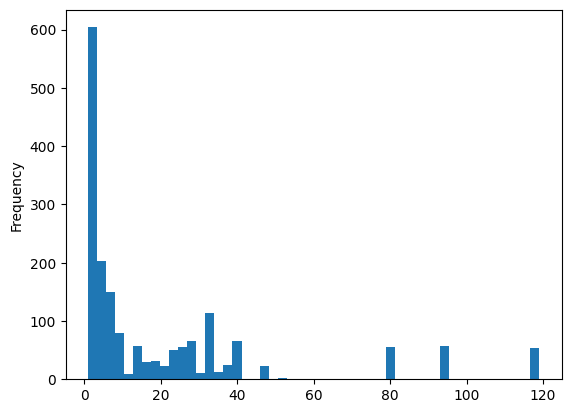

In [27]:
# Calculate how many rows from nts_matching are matched onto each hid in spc_matching,
spc_nts['count'] = spc_nts.groupby('hid')['HouseholdID'].transform('count')

# plot a histogram of the counts, and add a line for the mean value


spc_nts_hist = spc_nts.drop_duplicates(subset='hid')


spc_nts_hist['count'].plot(kind='hist', bins=50)

Store the results in a dictionary, 

- Key: SPC hid
- Value: List of NTS Household IDs



In [22]:
# Each hid in spc_matching is joined onto multiple HouseholdID in nts_matching.
# Create a dictionary to store the hid to HouseholdID matches

# Initialize an empty dictionary
hid_to_HouseholdID = {}

# Loop through the DataFrame
for index, row in spc_nts.iterrows():
    # Get the hid and HouseholdID from the row
    hid = row['hid']
    HouseholdID = row['HouseholdID']

    # If the hid is already a key in the dictionary, append the HouseholdID to its list
    if hid in hid_to_HouseholdID:
        hid_to_HouseholdID[hid].append(HouseholdID)
    # If the hid is not a key in the dictionary, add it with a new list that contains the HouseholdID
    else:
        hid_to_HouseholdID[hid] = [HouseholdID]
